In [122]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats.mstats import winsorize
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor

In [123]:
df = pd.read_csv('../data/raw_data/aapl.csv')
df.columns = df.columns.str.lower()
df['date'] = pd.to_datetime(df['date'])
df = df.set_index('date')
df = df.loc['2019-01-01':'2024-12-31']
df = df.astype(float)

In [124]:
df

,open,high,low,close,volume
date,,,,,
2019-01-02,36.944469,37.889013,36.787045,37.667187,148158800.0
2019-01-03,34.342207,34.757234,33.869937,33.915257,365248800.0
2019-01-04,34.473394,35.432248,34.299275,35.363075,234428400.0
2019-01-07,35.468029,35.499037,34.800170,35.284367,219111200.0
2019-01-08,35.673157,36.212216,35.425097,35.956997,164101200.0
...,...,...,...,...,...
2024-12-24,255.209412,257.926411,255.009620,257.916443,23234700.0
2024-12-26,257.906429,259.814335,257.347047,258.735504,27237100.0
2024-12-27,257.546826,258.415896,252.782075,255.309296,42355300.0


In [125]:
cols = ['sma_7', 'sma_21', 'sma_50', 'sma_200']
for col in cols:
    df[col] = df['close'].rolling(window=int(col.split('_')[1]), min_periods=1).mean()

In [126]:
cols = ['ema_7', 'ema_21', 'ema_50', 'ema_200']
for col in cols:
    df[col] = df['close'].ewm(span=int(col.split('_')[1]), adjust=False).mean()

In [127]:
df['returns'] = np.log(df['close'] / df['close'].shift(1))

In [128]:
cols=['std_returns_21', 'std_returns_252']
for col in cols:
    df[col] = df['returns'].rolling(window=int(col.split('_')[2]), min_periods=1).std()

In [129]:
df['upper_band'] = df['sma_21'] + (2 * df['std_returns_21'])
df['lower_band'] = df['sma_21'] - (2 * df['std_returns_21'])

In [130]:
cols = ['momentum_7', 'momentum_21']
for col in cols:
    df[col] = df['close'] - df['close'].shift(int(col.split('_')[1]))

In [131]:
delta = df['close'].diff(1)
gain = pd.Series(np.where(delta > 0, delta, 0), index=df.index)
loss = pd.Series(np.where(delta < 0, -delta, 0), index=df.index)
avg_gain = gain.ewm(span=14, adjust=False).mean()
avg_loss = loss.ewm(span=14, adjust=False).mean()
rs = np.where(avg_loss == 0, 0, avg_gain / avg_loss)
df['rsi_14'] = 100 - (100 / (1 + rs))

In [132]:
df['high_low'] = df['high'] - df['low']
df['high_close'] = abs(df['high'] - df['close'].shift(1))
df['low_close'] = abs(df['low'] - df['close'].shift(1))
df['tr'] = df[['high_low', 'high_close', 'low_close']].max(axis=1)

df['+dm'] = np.where(df['high'].diff(1) > df['low'].diff(1), df['high'].diff(1), 0)
df['-dm'] = np.where(df['low'].diff(1) > df['high'].diff(1), df['low'].diff(1), 0)

In [133]:
df['tr_smooth'] = df['tr'].ewm(span=14, adjust=False).mean()
df['+dm_smooth'] = df['+dm'].ewm(span=14, adjust=False).mean()
df['-dm_smooth'] = df['-dm'].ewm(span=14, adjust=False).mean()

In [134]:
df['+di'] = (df['+dm_smooth'] / df['tr_smooth']) * 100
df['-di'] = (df['-dm_smooth'] / df['tr_smooth']) * 100

In [135]:
df['dx'] = (abs(df['+di'] - df['-di']) / (df['+di'] + df['-di'])) * 100
df['adx'] = df['dx'].ewm(span=14, adjust=False).mean()

In [136]:
df['ema_12'] = df['close'].ewm(span=12, adjust=False).mean()
df['ema_26'] = df['close'].ewm(span=26, adjust=False).mean()
df['macd'] = df['ema_12'] - df['ema_26']
df['macd_signal'] = df['macd'].ewm(span=9, adjust=False).mean()

In [137]:
drop_cols = [
    'high_low', 'high_close', 'low_close', 'tr', '+dm', '-dm', 
    'tr_smooth', '+dm_smooth', '-dm_smooth', '+di', '-di', 'dx'
]
df = df.drop(drop_cols, axis=1)

In [138]:
df = df.iloc[252:]

In [139]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1258 entries, 2020-01-02 to 2024-12-31
Data columns (total 26 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   open             1258 non-null   float64
 1   high             1258 non-null   float64
 2   low              1258 non-null   float64
 3   close            1258 non-null   float64
 4   volume           1258 non-null   float64
 5   sma_7            1258 non-null   float64
 6   sma_21           1258 non-null   float64
 7   sma_50           1258 non-null   float64
 8   sma_200          1258 non-null   float64
 9   ema_7            1258 non-null   float64
 10  ema_21           1258 non-null   float64
 11  ema_50           1258 non-null   float64
 12  ema_200          1258 non-null   float64
 13  returns          1258 non-null   float64
 14  std_returns_21   1258 non-null   float64
 15  std_returns_252  1258 non-null   float64
 16  upper_band       1258 non-null   float64
 

In [140]:
df.isna().sum().sum()

0

In [141]:
def count_outliers(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = series[(series < lower_bound) | (series > upper_bound)]
    return len(outliers)

In [142]:
cols = df.columns
outliers = {}
for col in cols:
    outliers[col] = count_outliers(df[col])
    print(f'{col}: {outliers[col]}')

open: 5
high: 6
low: 4
close: 7
volume: 68
sma_7: 6
sma_21: 0
sma_50: 0
sma_200: 0
ema_7: 6
ema_21: 0
ema_50: 0
ema_200: 0
returns: 53
std_returns_21: 56
std_returns_252: 0
upper_band: 0
lower_band: 0
momentum_7: 17
momentum_21: 4
rsi_14: 0
adx: 291
ema_12: 4
ema_26: 0
macd: 1
macd_signal: 1


In [143]:
def winsorization(df, columns, limits=(0.01, 0.01)):
    df = df.copy()
    for col in columns:
        df[col] = winsorize(df[col], limits=limits)
    return df

In [144]:
def clipping(df, columns, lower=1, upper=99):
    df = df.copy()
    for col in columns:
        lower_bound, upper_bound = df[col].quantile([lower/100, upper/100])
        df[col] = df[col].clip(lower_bound, upper_bound)
    return df

In [145]:
print(df[['volume', 'returns', 'adx', 'std_returns_21', 'std_returns_252']].describe(percentiles=[0.01, 0.25, 0.5, 0.75, 0.99]))

             volume      returns          adx  std_returns_21  std_returns_252
count  1.258000e+03  1258.000000  1258.000000     1258.000000      1258.000000
mean   9.057384e+07     0.001000    47.645637        0.017981         0.019356
std    5.325460e+07     0.019942   372.470440        0.008764         0.005059
min    2.323470e+07    -0.137708 -4477.130246        0.006038         0.011902
1%     3.238113e+07    -0.051599  -771.848933        0.008246         0.012056
25%    5.546825e+07    -0.008459    19.741182        0.012497         0.014997
50%    7.627980e+07     0.001209    37.220523        0.015893         0.018674
75%    1.077425e+08     0.012000    65.668173        0.020647         0.022312
99%    3.199615e+08     0.051787  1461.525567        0.062114         0.029719
max    4.265100e+08     0.113158  2723.484088        0.067330         0.029897


In [146]:
if (df['adx'] < 0).any():
    df['adx'] = np.log1p(df['adx'] - df['adx'].min() + 1)

df['volume'] = np.log1p(df['volume'])  
df['std_returns_21'] = np.log1p(df['std_returns_21'])  
df['std_returns_252'] = np.log1p(df['std_returns_252'])  

In [147]:
df = winsorization(df, ['returns', 'adx'])
df = clipping(df, ['volume', 'returns', 'std_returns_21', 'std_returns_252', 'adx'])

c:\Users\santi\anaconda3\Lib\site-packages\numpy\lib\function_base.py:4824: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(
c:\Users\santi\anaconda3\Lib\site-packages\numpy\lib\function_base.py:4824: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(
c:\Users\santi\anaconda3\Lib\site-packages\numpy\lib\function_base.py:4824: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(
c:\Users\santi\anaconda3\Lib\site-packages\numpy\lib\function_base.py:4824: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(
c:\Users\santi\anaconda3\Lib\site-packages\numpy\lib\function_base.py:4824: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(


In [148]:
print(df[['volume', 'returns', 'adx', 'std_returns_21', 'std_returns_252']].describe(percentiles=[0.01, 0.25, 0.5, 0.75, 0.99]))

            volume      returns          adx  std_returns_21  std_returns_252
count  1258.000000  1258.000000  1258.000000     1258.000000      1258.000000
mean     18.193719     0.000949     8.418748        0.017765         0.019159
std       0.478694     0.018044     0.050412        0.008378         0.004956
min      17.292987    -0.051599     8.217933        0.008212         0.011983
1%       17.299978    -0.050896     8.225657        0.008213         0.011984
25%      17.831321    -0.008459     8.411582        0.012419         0.014886
50%      18.149919     0.001209     8.415460        0.015768         0.018502
75%      18.495255     0.012000     8.421739        0.020436         0.022067
99%      19.582844     0.051501     8.688241        0.060106         0.029285
max      19.583710     0.051787     8.689571        0.060262         0.029286


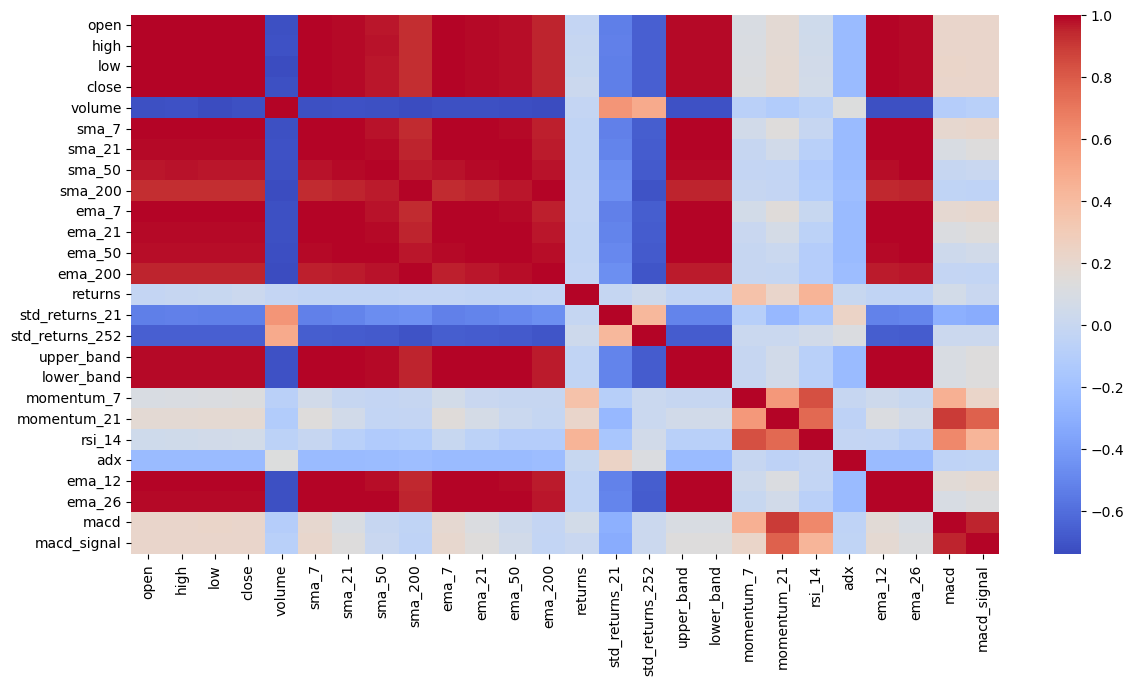

In [149]:
plt.figure(figsize=(14, 7))
sns.heatmap(df.corr(), cmap='coolwarm', annot=False, fmt=".2f")
plt.show()

In [150]:
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df)

In [151]:
pca = PCA(n_components=0.95)
pca.fit(df_scaled)

PCA(n_components=0.95)

Explained Variance (95%): [0.6604079  0.14905423 0.05440275 0.03728906 0.02952954 0.02484102]


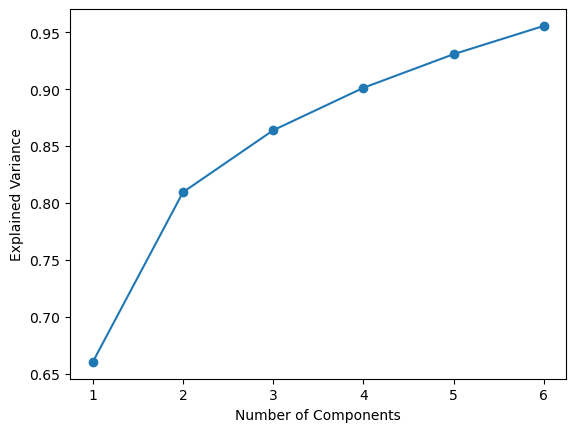

In [152]:
print('Explained Variance (95%):', pca.explained_variance_ratio_)
plt.plot(range(1, len(pca.explained_variance_ratio_)+1), pca.explained_variance_ratio_.cumsum(), marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance')
plt.show()

In [153]:
X = df.drop('close', axis=1)
y = df['close']

In [154]:
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X, y)

RandomForestRegressor(random_state=42)

In [155]:
importances = rf.feature_importances_
sorted_indices = np.argsort(importances)[::-1]

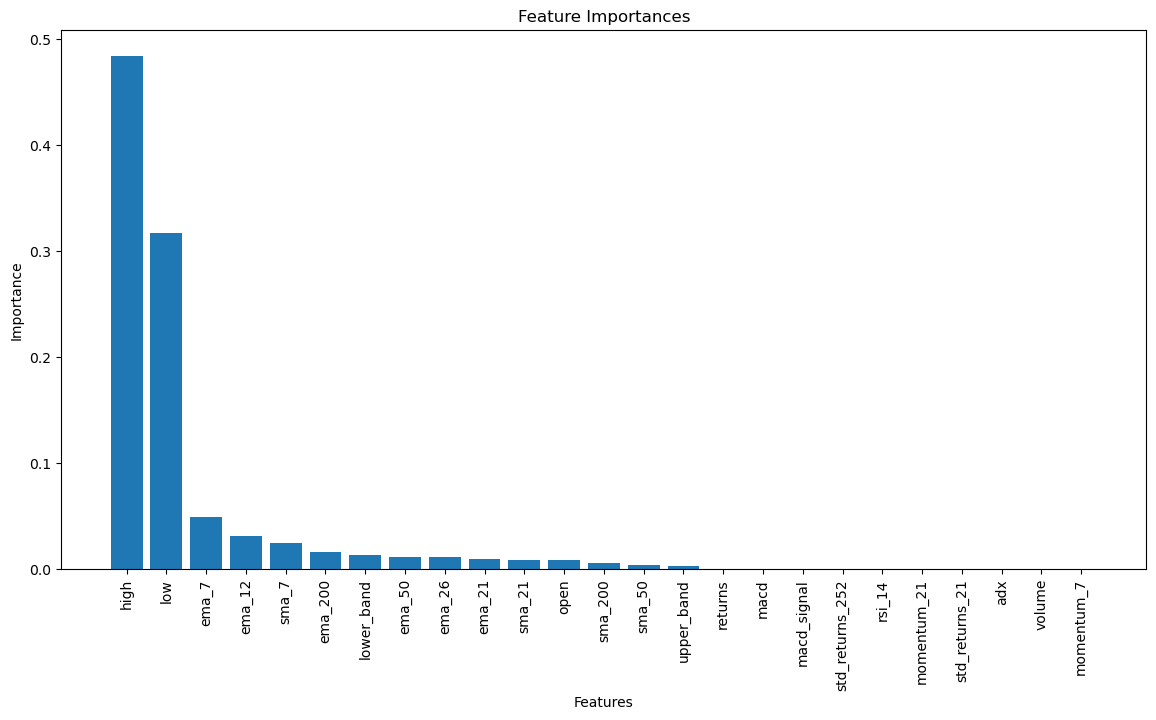

In [156]:
plt.figure(figsize=(14, 7))
plt.bar(range(len(importances)), importances[sorted_indices], align='center')
plt.xticks(range(len(importances)), X.columns[sorted_indices], rotation=90)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importances')
plt.show()

In [157]:
print('Feature Importances:')
for i in range(len(importances)):
    print(f'{X.columns[sorted_indices[i]]}: {importances[sorted_indices[i]]}')

Feature Importances:
high: 0.4847590295102007
low: 0.3171194615735006
ema_7: 0.04947327938523762
ema_12: 0.03131760567863966
sma_7: 0.024902095098624094
ema_200: 0.015991083797811938
lower_band: 0.013396580383359764
ema_50: 0.011555598188430428
ema_26: 0.011397263655641986
ema_21: 0.009321964211827165
sma_21: 0.008576287341656875
open: 0.008472350766729858
sma_200: 0.0060855103788758635
sma_50: 0.003761324924223311
upper_band: 0.003166347552265603
returns: 0.00017540849795733536
macd: 0.00015294032581584325
macd_signal: 7.301399055855505e-05
std_returns_252: 6.924532662991371e-05
rsi_14: 4.899210278342069e-05
momentum_21: 4.32075053099583e-05
std_returns_21: 4.231080269502735e-05
adx: 3.6029039219494226e-05
volume: 3.246082712786139e-05
momentum_7: 3.060913487711336e-05


In [158]:
df.corr()

,open,high,low,close,volume,sma_7,sma_21,sma_50,sma_200,ema_7,...,upper_band,lower_band,momentum_7,momentum_21,rsi_14,adx,ema_12,ema_26,macd,macd_signal
open,1.000000,0.999400,0.999401,0.998661,-0.723917,0.997242,0.988965,0.972347,0.930445,0.998056,...,0.988954,0.988975,0.103193,0.176454,0.041053,-0.240130,0.996012,0.990030,0.217490,0.216489
high,0.999400,1.000000,0.999260,0.999398,-0.715438,0.997252,0.989282,0.972932,0.931483,0.998162,...,0.989273,0.989290,0.107765,0.176451,0.045100,-0.240933,0.996151,0.990344,0.214915,0.213467
low,0.999401,0.999260,1.000000,0.999395,-0.732529,0.996722,0.988034,0.971537,0.930256,0.997684,...,0.988020,0.988047,0.114144,0.183257,0.054167,-0.237345,0.995418,0.989256,0.220083,0.216658
close,0.998661,0.999398,0.999395,1.000000,-0.724382,0.996533,0.988192,0.971945,0.930670,0.997600,...,0.988182,0.988203,0.118350,0.183148,0.058338,-0.239196,0.995378,0.989392,0.217476,0.213808
volume,-0.723917,-0.715438,-0.732529,-0.724382,1.000000,-0.722248,-0.716823,-0.718150,-0.732789,-0.723172,...,-0.716732,-0.716913,-0.073595,-0.119885,-0.063082,0.130073,-0.722086,-0.721475,-0.102309,-0.079997
sma_7,0.997242,0.997252,0.996722,0.996533,-0.722248,1.000000,0.994331,0.978551,0.935695,0.999788,...,0.994322,0.994339,0.049921,0.144098,-0.009292,-0.240200,0.999248,0.994890,0.193778,0.206331
sma_21,0.988965,0.989282,0.988034,0.988192,-0.716823,0.994331,1.000000,0.990275,0.946138,0.994681,...,1.000000,1.000000,-0.009965,0.053499,-0.084890,-0.236654,0.997565,0.999298,0.103067,0.133931
sma_50,0.972347,0.972932,0.971537,0.971945,-0.718150,0.978551,0.990275,1.000000,0.963667,0.979296,...,0.990288,0.990261,-0.024116,-0.026332,-0.122362,-0.235692,0.984167,0.993320,-0.008894,0.004589
sma_200,0.930445,0.931483,0.930256,0.930670,-0.732789,0.935695,0.946138,0.963667,1.000000,0.936598,...,0.946147,0.946129,-0.007391,-0.022728,-0.108642,-0.217496,0.941000,0.951947,-0.041126,-0.050002
ema_7,0.998056,0.998162,0.997684,0.997600,-0.723172,0.999788,0.994681,0.979296,0.936598,1.000000,...,0.994672,0.994689,0.059117,0.144396,-0.002077,-0.239840,0.999404,0.995242,0.190884,0.201610


In [159]:
df['log_close'] = np.log(df['close'])
df = df.iloc[:-1]
drop_cols = ['open', 'close', 'sma_50', 'sma_200', 'ema_50', 'ema_200', 'momentum_7', 'momentum_21', 'rsi_14', 'adx', 'macd_signal', 'macd', 'volume', 'upper_band', 'lower_band']
df = df.drop(drop_cols, axis=1)
df.columns

Index(['high', 'low', 'sma_7', 'sma_21', 'ema_7', 'ema_21', 'returns',
       'std_returns_21', 'std_returns_252', 'ema_12', 'ema_26', 'log_close'],
      dtype='object')

In [160]:
X = df.drop('log_close', axis=1)
y = df['log_close']

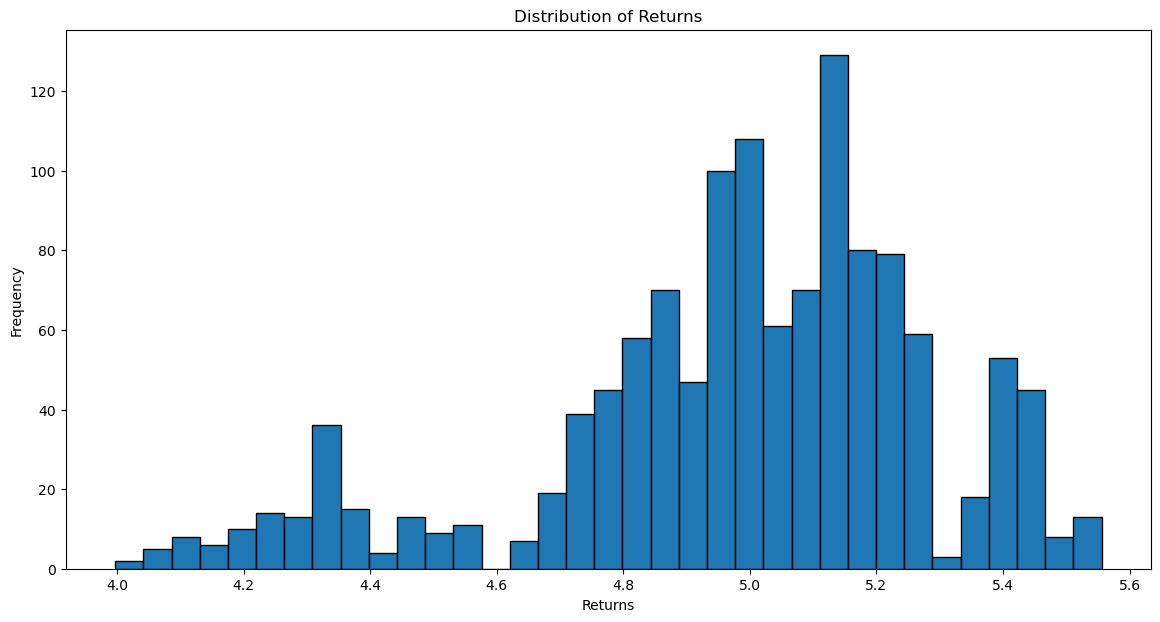

In [161]:
plt.figure(figsize=(14, 7))
plt.hist(y, bins=int(np.sqrt(len(df))), edgecolor='black')
plt.xlabel('Returns')
plt.ylabel('Frequency')
plt.title('Distribution of Returns')
plt.show()

{'whiskers': [<matplotlib.lines.Line2D at 0x20417534d50>,
 'caps': [<matplotlib.lines.Line2D at 0x20417535290>,
 'boxes': [<matplotlib.lines.Line2D at 0x20417350b50>],
 'medians': [<matplotlib.lines.Line2D at 0x20417535a50>],
 'fliers': [<matplotlib.lines.Line2D at 0x20418795ad0>],
 'means': []}

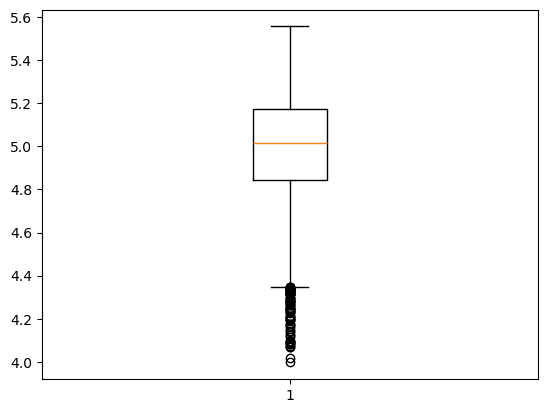

In [162]:
plt.boxplot(y)

In [163]:
df.to_csv('../data/pre_train/aapl.csv', index=True)